In [3]:
import pandas as pd
import django, sys, os
sys.path.append('/home/max/software/django-tmv/tmv_mcc-apsis/BasicBrowser')
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier
import numpy as np
import matplotlib.pyplot as plt
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from utils.text import *
from scoping.models import *
import scoping.utils.learning_utils as lu

django.db.connection.close()

p = Project.objects.get(pk=178)
p

<Project: Regional Impacts Map>

In [4]:
df = pd.read_csv('../data/category_predictions.csv')
print(df.shape)
df = df[(df['12 - Terrestrial ES']==1) | (df['12 - Terrestrial ES - prediction']>0.3)].reset_index(drop=True)
print(df.shape)
df.head()

(15675, 229)
(5670, 229)


,id,content,title,wosarticle__de,wosarticle__wc,ar5,seen,relevant,12 - Coastal and marine Ecosystems,12 - Human and managed,...,8 - 8.09. Mixed methods,8 - 8.10. Case studies,8 - 8.11. Remote sensing,9 - observations,12 - Physical systems,"12 - Rivers, lakes, and soil moisture - prediction",12 - Coastal and marine Ecosystems - prediction,12 - Terrestrial ES - prediction,"12 - Mountains, snow and ice - prediction",12 - Human and managed - prediction
0,654706,Phenology affects the abiotic and biotic condi...,Dissecting the Contributions of Plasticity and...,plasticity; local adaptation; space-for-time s...,['Ecology; Evolutionary Biology'],0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,0.004216,0.004261,0.991049,0.003913,0.018551
1,1281441,Studying the differences in phenology among pl...,A comparative analysis of the spatio-temporal ...,Climate change; Phenology; Plantago asiatica; ...,['Agronomy; Forestry; Meteorology & Atmospheri...,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,0.007096,0.023445,0.976796,0.003401,0.004446
2,3302384,Climate change is altering global temperature ...,Reproductive consequences of climate variabili...,El Nino Southern Oscillation; Nesting chronolo...,['Ecology'],0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,0.007204,0.099728,0.957857,0.004328,0.003048
3,1285282,Extreme drought is likely to become more frequ...,Drought-induced changes in root biomass largel...,C sequestration; drought; root biomass; root m...,['Plant Sciences'],0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,0.048147,0.013038,0.808184,0.011619,0.013498
4,561245,Capsule The bioclimatic zone and habitat type ...,Declines in British-breeding populations of Af...,0,['Ornithology'],0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,0.011600,0.049947,0.953613,0.008062,0.004508


In [5]:
c = Category.objects.get(project=p, level=12, name="Terrestrial ES")
classes = []
for cl in c.equivalents.filter(level=4).exclude(name__contains='<hidden>'):
    if df[f"{cl.level} - {cl.name}"].sum()>45:
        classes.append(f"{cl.level} - {cl.name}")

print(classes)
y = df[classes]
y.shape

['4 - 47 Mortality and growth', '4 - 45 Distribution and range shifts (Terrestrial and freshwater)', '4 - 48 Physiology and metabolism', '4 - 46 Shifts in phenology (Terrestrial and freshwater)']


(5670, 4)

In [6]:
df[f"{cl.level} - {cl.name}"].sum()

11.0

In [7]:
rel_index = y[y.sum(axis=1)>0].index
rel_index

Int64Index([  29,   39,   51,   81,   98,  105,  113,  114,  145,  155,
            ...
            5523, 5542, 5547, 5560, 5567, 5595, 5611, 5632, 5633, 5656],
           dtype='int64', length=236)

In [9]:
vec = TfidfVectorizer(
    ngram_range=(1,2),
    min_df=2, max_df=0.9, strip_accents='unicode', 
    max_features=20000,
    tokenizer=snowball_stemmer(),
    #sublinear_tf=True
)

X = vec.fit_transform(df['content'].astype("str"))#+" " + df['title'].astype("str"))      
print(X.shape)

(5670, 20000)


In [10]:
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier

from importlib import reload  
reload(scoping.utils.learning_utils)
y = np.matrix(df[classes])
print(y.shape)

multimodels = [
    {
        'title': 'One vs rest SVC balanced', 
        'model': OneVsRestClassifier(SVC(kernel='linear', class_weight="balanced", probability=True))
    }, 
    
]

#multimodels_ar5, metrics = lu.cross_validate_models(X, y, multimodels, seen_index, classes=classes)
multimodels_ar5, metrics, df = lu.cross_validate_models(X, y, multimodels, rel_index, n_splits=6, classes=classes, df = df)


(5670, 4)
1
2
3


/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


4


/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


5
6


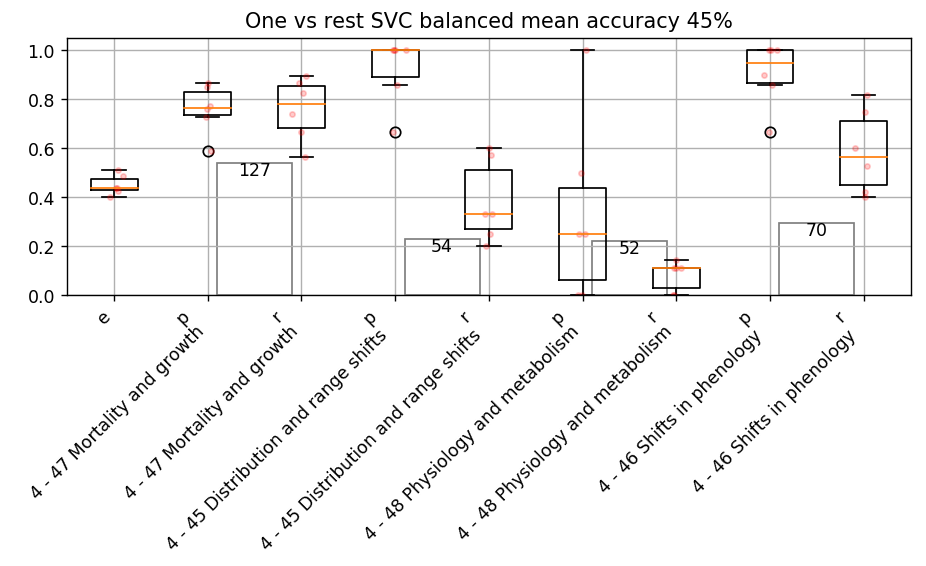

In [11]:
fig, axs = plt.subplots(1, 1,dpi=125,figsize=(8,6),sharey=False,sharex=True)   
if str(type(axs))=="<class 'matplotlib.axes._subplots.AxesSubplot'>":
    axs = [axs]
lu.plot_model_output(multimodels_ar5, metrics, fig, axs)
ax = axs[0]
for i,m in enumerate(metrics):
    if len(m)>2:
        v,c = m.split('\n')
        s = df[c].sum()/len(rel_index)
        if v=="p":
            ax.text(i+1.5,s-0.03,int(df[c].sum()),ha="center",va="center")
            ax.bar(i+1.5,s,color="none",edgecolor="grey")
        
ax.set_xticklabels([x.split('(')[0] for x in metrics], rotation=45, ha="right")
plt.show()

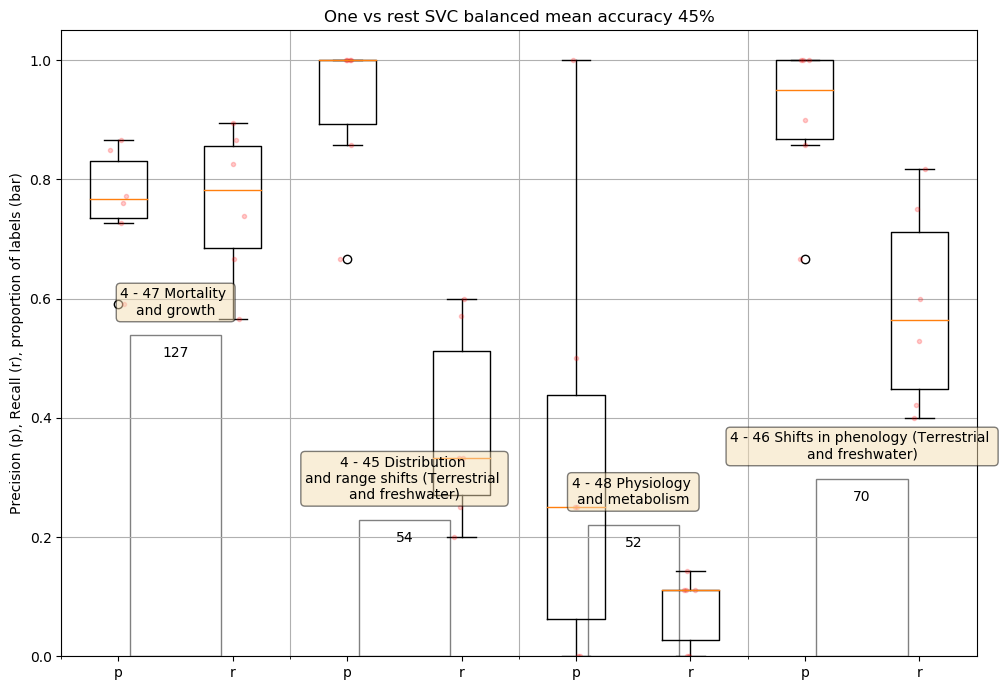

In [13]:
fig, axs = plt.subplots(1, 1,dpi=100,figsize=(10,7),sharey=False,sharex=True)   
if str(type(axs))=="<class 'matplotlib.axes._subplots.AxesSubplot'>":
    axs = [axs]
    
pmetrics = [m for m in metrics if m!="e"]
lu.plot_model_output(multimodels_ar5, pmetrics , fig, axs)
ax = axs[0]
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
for i,m in enumerate(metrics):
    if len(m)>2:
        v,c = m.split('\n')
        s = df[c].sum()/len(rel_index)
        if v=="p":
            ax.text(i+.5,s-0.03,int(df[c].sum()),ha="center",va="center")
            ax.text(i+.5,max([.22,s+0.03]), c.replace('12 - ','').replace('and','\nand'),va="bottom",ha="center",bbox=props)
            ax.bar(i+.5,s,color="none",edgecolor="grey")
        
ax.set_xticklabels([x.split('\n')[0] for x in pmetrics],rotation=0,ha="center")
ax.grid(False,axis="x")
ax.grid(True,which="minor",axis="x")
ax.set_xticks([i+.5 for i,x in enumerate(pmetrics) if i%2==0],minor=True)
ax.set_ylabel('Precision (p), Recall (r), proportion of labels (bar)')
fig.tight_layout()
plt.savefig(f'../plots/progress/cats_prediction.pdf',bbox_inches="tight")

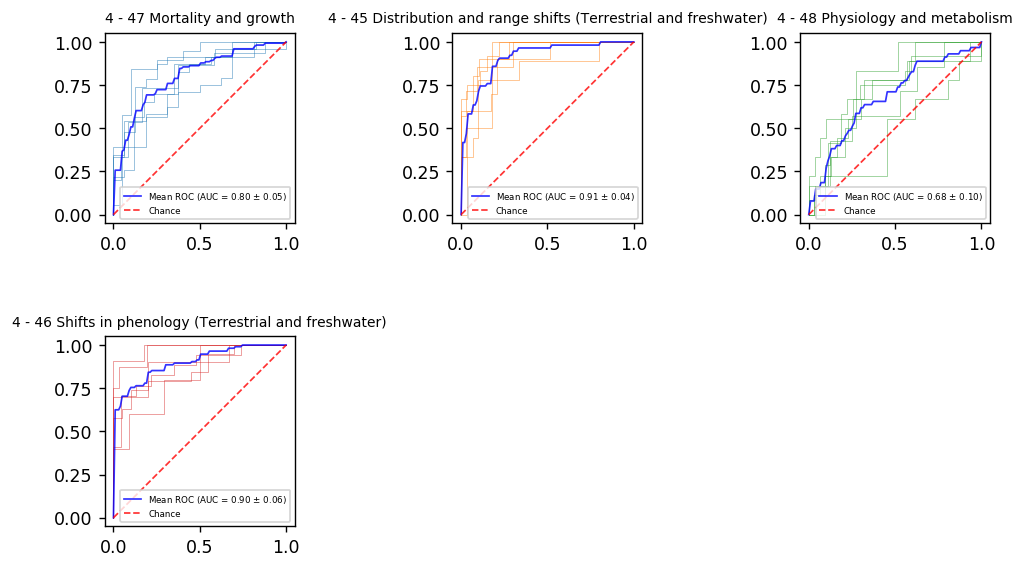

In [14]:
from scipy import interp
fig = plt.figure(dpi=125, figsize=(8,5))
for model in multimodels_ar5:
    for j,c in enumerate(classes):
        ax = fig.add_subplot(2,3,j+1)
        mean_fpr = np.linspace(0, 1, 100)
        mean_auc = np.mean(model[f'auc\n{c}'])
        std_auc = np.std(model[f'auc\n{c}'])
        tprs = []
        for i in range(len(model['i'])):
            viz = ax.plot(
                model[f'fpr\n{c}'][i],
                model[f'tpr\n{c}'][i],
                lw=0.5,
                alpha=0.5,
                color=f"C{j}"
            )
            
            interp_tpr = interp(mean_fpr, model[f'fpr\n{c}'][i], model[f'tpr\n{c}'][i])
            interp_tpr[0] = 0.0
            tprs.append(interp_tpr)
            
        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0
        ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=1, alpha=.8)
        ax.set_title(c,fontsize=8)
        ax.plot([0, 1], [0, 1], linestyle='--', lw=1, color='r',
            label='Chance', alpha=.8)

        ax.legend(fontsize=5)
        ax.set_aspect("equal")
            
fig.tight_layout()